# House Prices - Advanced Regression Techniques

#### 20213013 컴퓨터공학과 김어진

## 데이터 로드

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 파일 경로 설정
base_path = r"C:\Users\chosun\Downloads\house-prices-advanced-regression-techniques"

# data_description.txt는 일반 텍스트 파일로 읽기
with open(f"{base_path}/data_description.txt", 'r') as f:
    data_description = f.read()

# CSV 파일들 로드
df_submission = pd.read_csv(f"{base_path}/sample_submission.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")
df_train = pd.read_csv(f"{base_path}/train.csv")

## 데이터 정규화

In [64]:
from sklearn.preprocessing import MinMaxScaler

# 목표 변수 Min-Max 스케일링
scaler = MinMaxScaler()

# y_train과 y_val을 Min-Max 방식으로 스케일링
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)


## 활성화 함수

In [65]:
# ReLU 활성화 함수 정의
def relu(x):
    return np.maximum(0, x)

# ReLU 함수의 미분 (역전파에서 사용)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)


In [66]:
## 배치 정규화
class Layer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros(output_size)
        self.gamma = np.ones(output_size)  # Scale factor
        self.beta = np.zeros(output_size)  # Shift factor
    
    def forward(self, input_data):
        self.z = np.dot(input_data, self.weights) + self.bias
        self.batch_mean = np.mean(self.z, axis=0)
        self.batch_var = np.var(self.z, axis=0)
        self.z_normalized = (self.z - self.batch_mean) / np.sqrt(self.batch_var + 1e-8)
        self.output = self.gamma * self.z_normalized + self.beta
        return self.output


## 은닉층

In [67]:
class HiddenLayer:
    def __init__(self, input_size, output_size):
        # 가중치 초기화 (정규 분포로 초기화)
        self.weights = np.random.randn(input_size, output_size) * 0.01
        # 편향 초기화 (0으로 초기화)
        self.bias = np.zeros((1, output_size))
        
    def forward(self, input_data):
        # 입력 데이터를 가중치와 편향을 통해 선형 변환
        self.input_data = input_data
        self.z = np.dot(self.input_data, self.weights) + self.bias
        # 활성화 함수 (ReLU) 적용
        self.output = relu(self.z)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # 역전파를 위한 가중치와 편향 업데이트
        # ReLU의 미분
        relu_grad = relu_derivative(self.z)
        output_gradient = output_gradient * relu_grad
        
        # 가중치의 기울기 계산
        weight_gradient = np.dot(self.input_data.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        
        # 가중치 및 편향 업데이트
        self.weights -= learning_rate * weight_gradient
        self.bias -= learning_rate * bias_gradient
        
        # 은닉층에 대한 기울기를 반환 (다음 층에 전달)
        input_gradient = np.dot(output_gradient, self.weights.T)
        return input_gradient


## MLP 모델

In [68]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        # 은닉층, 출력층 초기화
        self.hidden_layer = HiddenLayer(input_size, hidden_size)
        self.output_layer = HiddenLayer(hidden_size, output_size)
        self.loss_history = []  # 손실 값을 기록할 리스트 추가
        
    def forward(self, input_data):
        # 입력 -> 은닉층 -> 출력층 순으로 순전파
        hidden_output = self.hidden_layer.forward(input_data)
        output = self.output_layer.forward(hidden_output)
        return output
    
    def backward(self, output_gradient, learning_rate):
        # 출력층 -> 은닉층 -> 입력층 순으로 역전파
        hidden_gradient = self.output_layer.backward(output_gradient, learning_rate)
        self.hidden_layer.backward(hidden_gradient, learning_rate)
    
    def train(self, X_train, y_train, epochs, learning_rate, batch_size):
        # 훈련 과정
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                # 배치 학습
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                
                # 순전파
                predictions = self.forward(batch_X)
                
                # 손실 계산 (MSE)
                loss = np.mean((predictions - batch_y) ** 2)
                epoch_loss += loss
                
                # 출력층의 기울기 계산
                output_gradient = 2 * (predictions - batch_y) / batch_size
                
                # 역전파
                self.backward(output_gradient, learning_rate)
            
            # 에폭마다 평균 손실 출력
            epoch_loss /= len(X_train) // batch_size
            self.loss_history.append(epoch_loss)  # 손실 기록
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss}")

    
    def predict(self, X):
        # 예측
        predictions = self.forward(X)
        return predictions


## 모델 훈련

In [69]:
# 데이터 준비 (훈련용 데이터와 목표값 설정)
X_train = df_train[continuous_features].values  # 연속형 변수
y_train = df_train['SalePrice'].values.reshape(-1, 1)  # 목표 변수

# 훈련/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 목표 변수 Min-Max 스케일링
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# MLP 모델 초기화 (입력 13개, 은닉 64개, 출력 1개)
mlp_model = MLP(input_size=X_train.shape[1], hidden_size=64, output_size=1)

# 모델 훈련
mlp_model.train(X_train, y_train_scaled, epochs=1000, learning_rate=0.001, batch_size=32)

# 모델 예측
y_pred_scaled = mlp_model.predict(X_val)

# 예측된 값 복원 (원래 값으로 변환)
y_pred = scaler.inverse_transform(y_pred_scaled)

Epoch 0, Loss: 0.3474515834530142
Epoch 100, Loss: 0.05566583258758148
Epoch 200, Loss: 0.05566583258758148
Epoch 300, Loss: 0.05566583258758148
Epoch 400, Loss: 0.05566583258758148
Epoch 500, Loss: 0.05566583258758148
Epoch 600, Loss: 0.05566583258758148
Epoch 700, Loss: 0.05566583258758148
Epoch 800, Loss: 0.05566583258758148
Epoch 900, Loss: 0.05566583258758148


## 평가 및 예측

Final Validation MSE: 28388995583.25


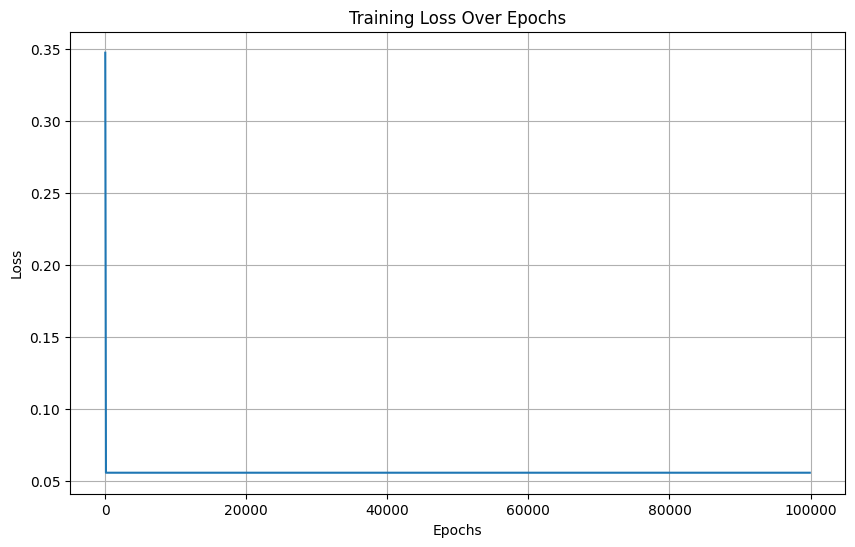

In [70]:
from sklearn.metrics import mean_squared_error

# 최종 MSE 계산
mse = np.mean((y_val - y_pred) ** 2)
print(f"Final Validation MSE: {mse}")

# 손실 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(mlp_model.loss_history) * 100, 100), mlp_model.loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'BostonHousing.csv'